In [598]:
import collections
import functools
import glob
import pickle
import itertools
import json
import os
import random
import sys
import numpy as np
import tqdm
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# If domainbed is a custom module, you might need to adjust its imports or setup
from domainbed import datasets
from domainbed import algorithms
from domainbed.lib import misc, reporting
from domainbed import model_selection
from domainbed.lib.query import Q
import warnings


In [774]:
# Copyright (c) Facebook, Inc. and its affiliates. All Rights Reserved
import itertools
import numpy as np

def get_test_records(records):
    """Given records with a common test env, get the test records (i.e. the
    records with *only* that single test env and no other test envs)"""
    return records.filter(lambda r: len(r['args']['test_envs']) == 1)

class SelectionMethod:
    """Abstract class whose subclasses implement strategies for model
    selection across hparams and timesteps."""

    def __init__(self):
        raise TypeError

    @classmethod
    def run_acc(self, run_records):
        """
        Given records from a run, return a {val_acc, test_acc} dict representing
        the best val-acc and corresponding test-acc for that run.
        """
        raise NotImplementedError

    @classmethod
    def hparams_accs(self, records):
        """
        Given all records from a single (dataset, algorithm, test env) pair,
        return a sorted list of (run_acc, records) tuples.
        """

        return (records.group('args.hparams_seed')
            .map(lambda _, run_records:
                (
                    self.run_acc(run_records),
                    run_records
                )
            ).filter(lambda x: x[0] is not None)
            .sorted(key=lambda x: x[0]['val_acc'])[::-1]
        )

    @classmethod
    def sweep_acc(self, records):
        """
        Given all records from a single (dataset, algorithm, test env) pair,
        return the mean test acc of the k runs with the top val accs.
        """
        _hparams_accs = self.hparams_accs(records)
        a = _hparams_accs
        # for i in range(len(a)):
        #     print(a[i][0]['val_acc'], a[i][0]['test_acc'])
        #     print(f"Hparams {(a[i][1][0]['hparams']['grad_alpha'], a[i][1][0]['hparams']['grad_alpha'],  a[i][1][0]['hparams']['penalty_anneal_iters'])}")
        # if a[0][1][0]['args']['algorithm'] == 'HessianAlignment':
        # if a[0][1][0]['args']['algorithm'] in ['HessianAlignment'] and a[0][1][0]['args']['dataset'] == 'PACS':
        # if a[0][1][0]['args']['algorithm'] in ['HessianAlignment'] and a[0][1][0]['args']['dataset'] == 'TerraIncognita':
        # if a[0][1][0]['args']['algorithm'] in ['HessianAlignment'] and a[0][1][0]['args']['dataset'] == 'VLCS':
        # if a[0][1][0]['args']['algorithm'] in ['HessianAlignment'] and a[0][1][0]['args']['dataset'] == 'ColoredMNIST':
        if a[0][1][0]['args']['algorithm'] in ['Fishr'] and a[0][1][0]['args']['dataset'] == 'ColoredMNIST':
            print(f"Algorithm: {a[0][1][0]['args']['algorithm']}")
            print(f"Best val acc and test for {a[0][1][0]['args']['dataset']}, env {a[0][1][0]['args']['test_envs']}:", a[0][0]['val_acc'], a[0][0]['test_acc'], "Hparams", (a[0][1][0]['hparams']))
           # print(f"Best hyperparameters for {a[0][1][0]['args']['dataset']}, env {a[0][1][0]['args']['test_envs']}:", 
           #       f"grad_alpha: {a[0][1][0]['hparams']['grad_alpha']}, hess_beta {a[0][1][0]['hparams']['hess_beta']}, "
           #       f"anneal_iters: {a[0][1][0]['hparams']['penalty_anneal_iters']}",
           #       f"output_dir: {a[0][1][0]['args']['output_dir']}")

        if len(_hparams_accs):
            # breakpoint()
            return _hparams_accs[0][0]['test_acc']
        else:
            return None

class OracleSelectionMethod(SelectionMethod):
    """Like Selection method which picks argmax(test_out_acc) across all hparams
    and checkpoints, but instead of taking the argmax over all
    checkpoints, we pick the last checkpoint, i.e. no early stopping."""
    name = "test-domain validation set (oracle)"

    @classmethod
    def run_acc(self, run_records):
        run_records = run_records.filter(lambda r:
            len(r['args']['test_envs']) == 1)
        if not len(run_records):
            return None
        test_env = run_records[0]['args']['test_envs'][0]
        test_out_acc_key = 'env{}_out_acc'.format(test_env)
        test_in_acc_key = 'env{}_in_acc'.format(test_env)
        chosen_record = run_records.sorted(lambda r: r['step'])[-1]
        return {
            'val_acc':  chosen_record[test_out_acc_key],
            'test_acc': chosen_record[test_in_acc_key]
        }

class IIDAccuracySelectionMethod(SelectionMethod):
    """Picks argmax(mean(env_out_acc for env in train_envs))"""
    name = "training-domain validation set"

    @classmethod
    def _step_acc(self, record):
        """Given a single record, return a {val_acc, test_acc} dict."""
        test_env = record['args']['test_envs'][0]
        val_env_keys = []
        for i in itertools.count():
            if f'env{i}_out_acc' not in record:
                break
            if i != test_env:
                val_env_keys.append(f'env{i}_out_acc')
        test_in_acc_key = 'env{}_in_acc'.format(test_env)
        return {
            'val_acc': np.mean([record[key] for key in val_env_keys]),
            'test_acc': record[test_in_acc_key]
        }

    @classmethod
    def run_acc(self, run_records):
        test_records = get_test_records(run_records)
        if not len(test_records):
            return None

        index_of_max = test_records.map(self._step_acc).map(lambda x: x['val_acc'])._list.index(
            max(test_records.map(self._step_acc).map(lambda x: x['val_acc'])))
        full_record_with_hyperparams = test_records[index_of_max]
        # print(f"Hyperparameters for {full_record_with_hyperparams['args']['dataset']}, env {full_record_with_hyperparams['args']['test_envs']}:", full_record_with_hyperparams['hparams'])
        return test_records.map(self._step_acc).argmax('val_acc')

class LeaveOneOutSelectionMethod(SelectionMethod):
    """Picks (hparams, step) by leave-one-out cross validation."""
    name = "leave-one-domain-out cross-validation"

    @classmethod
    def _step_acc(self, records):
        """Return the {val_acc, test_acc} for a group of records corresponding
        to a single step."""
        test_records = get_test_records(records)
        if len(test_records) != 1:
            return None

        test_env = test_records[0]['args']['test_envs'][0]
        n_envs = 0
        for i in itertools.count():
            if f'env{i}_out_acc' not in records[0]:
                break
            n_envs += 1
        val_accs = np.zeros(n_envs) - 1
        for r in records.filter(lambda r: len(r['args']['test_envs']) == 2):
            val_env = (set(r['args']['test_envs']) - set([test_env])).pop()
            val_accs[val_env] = r['env{}_in_acc'.format(val_env)]
        val_accs = list(val_accs[:test_env]) + list(val_accs[test_env+1:])
        if any([v==-1 for v in val_accs]):
            return None
        val_acc = np.sum(val_accs) / (n_envs-1)
        return {
            'val_acc': val_acc,
            'test_acc': test_records[0]['env{}_in_acc'.format(test_env)]
        }

    @classmethod
    def run_acc(self, records):
        step_accs = records.group('step').map(lambda step, step_records:
            self._step_acc(step_records)
        ).filter_not_none()
        if len(step_accs):
            return step_accs.argmax('val_acc')
        else:
            return None


In [775]:
def count_subdirectories_and_empty_ones(directory):
    
    num_subdirectories = 0
    num_empty_subdirectories = 0

    # Walk through all directories in the given directory
    for root, dirs, files in os.walk(directory):
        # Iterate over each directory in the current root
        for d in dirs:
            num_subdirectories += 1
            subdirectory_path = os.path.join(root, d)
            # Check if the directory is empty
            if not os.listdir(subdirectory_path):
                num_empty_subdirectories += 1

    return num_subdirectories, num_empty_subdirectories


# Specify the directory you want to inspect
# directory_path = 'results_vits_3600_32'
# directory_path = 'results_vits_terra_pacs'
# directory_path = 'results_vits_VLCS_ERM_Fishr'



# directory_path_list = ['results_vits_3600_32', 'results_vits_terra_pacs', 'results_vits_ERM_Fishr']

directory_path_list = ['results_vits_hessian_MNIST', 'results_vits_hessian_terra_anneal_0', 'results_vits_hessian_vlcs_anneal_2500','results_vits_hessian_pacs_anneal_2500', 'results_vits_hessian_vlcs_terra_anneal_2500', 'results_vits_hessian_vlcs_random2']
for directory_path in directory_path_list:
    # Get the count of subdirectories and empty subdirectories
    subdirectories, empty_subdirectories = count_subdirectories_and_empty_ones(directory_path)
    print(f"Total subdirectories: {subdirectories}")
    print(f"Empty subdirectories: {empty_subdirectories} in {directory_path} directory")

# Get the count of subdirectories and empty subdirectories
# subdirectories, empty_subdirectories = count_subdirectories_and_empty_ones(directory_path)
# print(f"Total subdirectories: {subdirectories}")
# print(f"Empty subdirectories: {empty_subdirectories}")

Total subdirectories: 30
Empty subdirectories: 0 in results_vits_hessian_MNIST directory
Total subdirectories: 20
Empty subdirectories: 0 in results_vits_hessian_terra_anneal_0 directory
Total subdirectories: 0
Empty subdirectories: 0 in results_vits_hessian_vlcs_anneal_2500 directory
Total subdirectories: 20
Empty subdirectories: 0 in results_vits_hessian_pacs_anneal_2500 directory
Total subdirectories: 80
Empty subdirectories: 0 in results_vits_hessian_vlcs_terra_anneal_2500 directory
Total subdirectories: 184
Empty subdirectories: 0 in results_vits_hessian_vlcs_random2 directory


In [776]:
def format_mean(data, latex):
    """Given a list of datapoints, return a string describing their mean and
    standard error"""
    if len(data) == 0:
        return None, None, "X"
    mean = 100 * np.mean(list(data))
    err = 100 * np.std(list(data) / np.sqrt(len(data)))
    if latex:
        return mean, err, "{:.1f} $\\pm$ {:.1f}".format(mean, err)
    else:
        return mean, err, "{:.1f} +/- {:.1f}".format(mean, err)

def print_table(table, header_text, row_labels, col_labels, colwidth=10,
    latex=True):
    """Pretty-print a 2D array of data, optionally with row/col labels"""
    print("")

    if latex:
        num_cols = len(table[0])
        print("\\begin{center}")
        print("\\adjustbox{max width=\\textwidth}{%")
        print("\\begin{tabular}{l" + "c" * num_cols + "}")
        print("\\toprule")
    else:
        print("--------", header_text)

    for row, label in zip(table, row_labels):
        row.insert(0, label)

    if latex:
        col_labels = ["\\textbf{" + str(col_label).replace("%", "\\%") + "}"
            for col_label in col_labels]
    table.insert(0, col_labels)

    for r, row in enumerate(table):
        misc.print_row(row, colwidth=colwidth, latex=latex)
        if latex and r == 0:
            print("\\midrule")
    if latex:
        print("\\bottomrule")
        print("\\end{tabular}}")
        print("\\end{center}")

def print_results_tables(records, selection_method, latex):
    """Given all records, print a results table for each dataset."""
    grouped_records = reporting.get_grouped_records(records).map(lambda group:
        { **group, "sweep_acc": selection_method.sweep_acc(group["records"]) }
    ).filter(lambda g: g["sweep_acc"] is not None)

    # read algorithm names and sort (predefined order)
    alg_names = Q(records).select("args.algorithm").unique()
    alg_names = ([n for n in algorithms.ALGORITHMS if n in alg_names] +
        [n for n in alg_names if n not in algorithms.ALGORITHMS])

    # read dataset names and sort (lexicographic order)
    dataset_names = Q(records).select("args.dataset").unique().sorted()
    dataset_names = [d for d in datasets.DATASETS if d in dataset_names]

    for dataset in dataset_names:
        if latex:
            print()
            print("\\subsubsection{{{}}}".format(dataset))
        test_envs = range(datasets.num_environments(dataset))
        # breakpoint()
        table = [[None for _ in [*test_envs, "Avg"]] for _ in alg_names]
        for i, algorithm in enumerate(alg_names):
            means = []
            for j, test_env in enumerate(test_envs):
                trial_accs = (grouped_records
                    .filter_equals(
                        "dataset, algorithm, test_env",
                        (dataset, algorithm, test_env)
                    ).select("sweep_acc"))
                mean, err, table[i][j] = format_mean(trial_accs, latex)
                means.append(mean)
            if None in means:
                table[i][-1] = "X"
            else:
                table[i][-1] = "{:.1f}".format(sum(means) / len(means))

        col_labels = [
            "Algorithm",
            *datasets.get_dataset_class(dataset).ENVIRONMENTS,
            "Avg"
        ]
        header_text = (f"Dataset: {dataset}, "
            f"model selection method: {selection_method.name}")
        print_table(table, header_text, alg_names, list(col_labels),
            colwidth=20, latex=latex)

    # Print an "averages" table
    if latex:
        print()
        print("\\subsubsection{Averages}")

    table = [[None for _ in [*dataset_names, "Avg"]] for _ in alg_names]
    for i, algorithm in enumerate(alg_names):
        means = []
        for j, dataset in enumerate(dataset_names):
            trial_averages = (grouped_records
                .filter_equals("algorithm, dataset", (algorithm, dataset))
                .group("trial_seed")
                .map(lambda trial_seed, group:
                    group.select("sweep_acc").mean()
                )
            )
            mean, err, table[i][j] = format_mean(trial_averages, latex)
            means.append(mean)
        if None in means:
            table[i][-1] = "X"
        else:
            table[i][-1] = "{:.1f}".format(sum(means) / len(means))

    col_labels = ["Algorithm", *dataset_names, "Avg"]
    header_text = f"Averages, model selection method: {selection_method.name}"
    print_table(table, header_text, alg_names, col_labels, colwidth=25,
        latex=latex)

In [785]:
# input_dir = "./results_vits_3600_32"
# input_dir = "./results_vits_terra_pacs"
input_dir = "./results_vits_hessian_MNIST"
# input_dir = "./results_vits_hessian_vlcs_anneal_3600"
# input_dir = "./results_vits_hessian_VLCS"
# input_dir = "./results_vits_hessian_pacs_anneal_2500"
# input_dir = "./results_vits_hessian_vlcs_terra_anneal_2500"
input_dir = "./results_vits_hessian_vlcs_random2"
# input_dir = "./results_vits_hessian_terra_anneal_0"
# 
latex = False
results_file = "results.tex" if latex else "results.txt"

records = reporting.load_records(input_dir)
# selection_methods = [
#     model_selection.IIDAccuracySelectionMethod,
#     model_selection.OracleSelectionMethod
# ]
selection_methods = [
    IIDAccuracySelectionMethod,
    OracleSelectionMethod,
]

for selection_method in selection_methods:
    print_results_tables(records, selection_method, latex)
    
    




-------- Dataset: ColoredMNIST, model selection method: training-domain validation set
Algorithm             +90%                  +80%                  -90%                  Avg                  
HessianAlignment      71.9 +/- 0.2          73.0 +/- 0.2          10.0 +/- 0.2          51.7                 

-------- Dataset: VLCS, model selection method: training-domain validation set
Algorithm             C                     L                     S                     V                     Avg                  
HessianAlignment      95.6 +/- 0.9          63.2 +/- 0.8          74.3 +/- 0.3          77.6 +/- 0.3          77.7                 

-------- Dataset: PACS, model selection method: training-domain validation set
Algorithm             A                     C                     P                     S                     Avg                  
HessianAlignment      82.7 +/- 1.0          74.4 +/- 0.5          96.4 +/- 0.4          66.1 +/- 1.1          79.9                 

---

In [786]:
 input_dir = "./results_vits_3600_32"
latex = False
results_file = "results.tex" if latex else "results.txt"

records = reporting.load_records(input_dir)
# selection_methods = [
#     model_selection.IIDAccuracySelectionMethod,
#     model_selection.OracleSelectionMethod
# ]
selection_methods = [
    IIDAccuracySelectionMethod,
    OracleSelectionMethod,
]

for selection_method in selection_methods:
    print_results_tables(records, selection_method, latex)
    
# a = selection_method.hparams_accs(records)
# grouped_records = reporting.get_grouped_records(records).map(lambda group:
#     { **group, "sweep_acc": selection_method.sweep_acc(group["records"]) }
# ).filter(lambda g: g["sweep_acc"] is not None)

Algorithm: Fishr
Best val acc and test for ColoredMNIST, env [2]: 0.852764680668667 0.10998017892537633 Hparams {'batch_size': 64, 'class_balanced': False, 'data_augmentation': True, 'ema': 0.9129082782560279, 'img_size': 224, 'lambda': 809.251247284292, 'lr': 0.00011906162909279594, 'model_type': 'ViT-S', 'nonlinear_classifier': False, 'penalty_anneal_iters': 4072, 'resnet18': False, 'resnet_dropout': 0.5, 'weight_decay': 0.0}
Algorithm: Fishr
Best val acc and test for ColoredMNIST, env [0]: 0.7353193313330476 0.7280372830512106 Hparams {'batch_size': 64, 'class_balanced': False, 'data_augmentation': True, 'ema': 0.9752755873490916, 'img_size': 224, 'lambda': 35.812115651904186, 'lr': 0.0026225693030627445, 'model_type': 'ViT-S', 'nonlinear_classifier': False, 'penalty_anneal_iters': 4399, 'resnet18': False, 'resnet_dropout': 0.0, 'weight_decay': 0.0}
Algorithm: Fishr
Best val acc and test for ColoredMNIST, env [0]: 0.7409987141020146 0.7181808442254125 Hparams {'batch_size': 64, 'cla

In [705]:
result_dir = './results_vits_3600_32'

for exp in os.listdir(result_dir):
    if not os.path.isdir(os.path.join(result_dir, exp)) or len(os.listdir(os.path.join(result_dir, exp))) == 0:
        continue
    with open(os.path.join(result_dir,exp, "results.jsonl")) as f:
        first_line = f.readline()
        first_line = json.loads(first_line)
    # if first_line['args']['algorithm'] == 'HessianAlignment' and first_line['args']['dataset'] == 'PACS' and first_line['args']['test_envs'] == [3]:
    if first_line['args']['algorithm'] == 'Fishr' and first_line['args']['dataset'] == 'PACS' and first_line['args']['test_envs'] == [3] :
        # load the jsonl file into a df
        df_fishr = pd.read_json(os.path.join(result_dir,exp, "results.jsonl"), lines=True)
        # if first_line['args']['algorithm'] == 'HessianAlignment' and first_line['args']['dataset'] == 'PACS' and first_line['args']['test_envs'] == [3]:
    if first_line['args']['algorithm'] == 'HessianAlignment' and first_line['args']['dataset'] == 'PACS' and first_line['args']['test_envs'] == [3] and first_line['hparams']['penalty_anneal_iters'] == 3600:
        # load the jsonl file into a df
        df= pd.read_json(os.path.join(result_dir,exp, "results.jsonl"), lines=True)
        

In [723]:
#extract the hyperparameters from df.hparams and args from df.args
df['grad_alpha'] = df['hparams'].apply(lambda x: x['grad_alpha'])
df['hess_beta'] = df['hparams'].apply(lambda x: x['hess_beta'])
df['penalty_anneal_iters'] = df['hparams'].apply(lambda x: x['penalty_anneal_iters'])
df['test_envs'] = df['args'].apply(lambda x: x['test_envs'])


In [724]:
df_fishr['test_envs'] = df_fishr['args'].apply(lambda x: x['test_envs'])

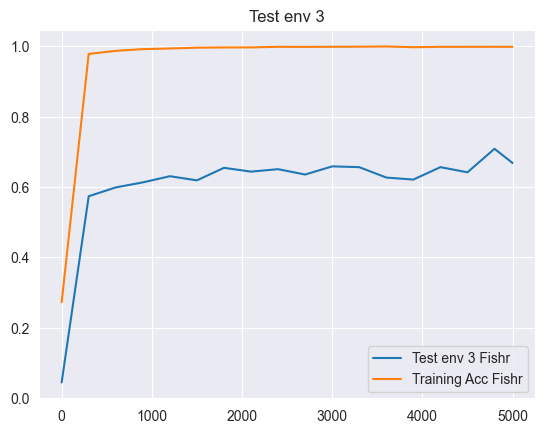

In [725]:
#plot the 'env{test_env}_out_acc' and average of 'env{non_test_env}_out_acc' 
for test_env in df['test_envs'][0]:
    # plt.plot(df['step'], df[f'env{test_env}_in_acc'], label=f'Test env {test_env} HessianAlignment')
    plt.plot(df_fishr['step'], df_fishr[f'env{test_env}_in_acc'], label=f'Test env {test_env} Fishr')
    # plt.plot(df['step'], df[[f'env{i}_in_acc' for i in range(4) if i != test_env]].mean(axis=1), label=f'Training Acc HessianAlignment')
    plt.plot(df_fishr['step'], df_fishr[[f'env{i}_in_acc' for i in range(4) if i != test_env]].mean(axis=1), label=f'Training Acc Fishr')
    plt.title(f'Test env {test_env}')
    plt.legend()
    plt.show()

Text(0.5, 1.0, 'Hessian and Gradient Penalty')

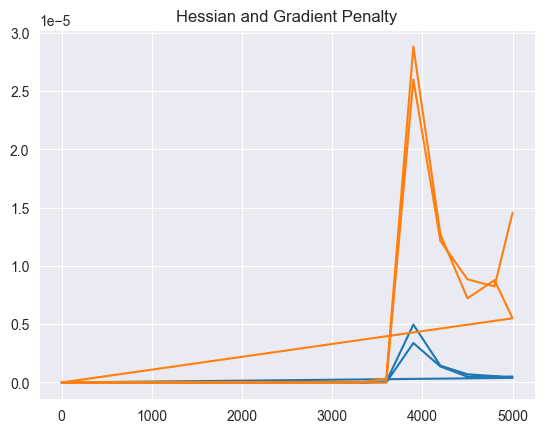

In [521]:
#plot the hess_penalty and grad_penalty
plt.plot(df['step'], df['hess_pen'])
plt.plot(df['step'], df['grad_pen'])
plt.title('Hessian and Gradient Penalty')
